# Introduction

In this notebook, **HDB housing price dataset**, provided by the Singapore goverment data webpage is used to do **HDB price prediction** using **Regression** with a fully-connected Feedforward neural network (sequential model).


In [0]:
# import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split

/Users/sindhuja/Applications/anaconda3/envs/tflow/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/sindhuja/Applications/anaconda3/envs/tflow/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/sindhuja/Applications/anaconda3/envs/tflow/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

## Loading the data

The pricing data for the period from 1Jan2017 to 30Sep2019 in CSV format from the following web page was downloaded on 31 Oct 2019 with the last update on 15 Oct 2019.

https://data.gov.sg/dataset/resale-flat-prices

The data is provided by Housing Development Board and updated on a monthly basis. 

* Importing the data using Pandas and examine the shape. There are 10 feature columns plus the predictor, the resale price (`resale_price`). 

In [0]:
# load the dataset
data = pd.read_csv('resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv', \
                   thousands=',')

## Understanding the data

There are three different types: integers (`int64`), floats (`float64`), and strings (`object`, categoricals). 

In [0]:
print(data.shape)

(58154, 11)


In [0]:
data.dtypes.value_counts()

object     8
float64    2
int64      1
dtype: int64

In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58154 entries, 0 to 58153
Data columns (total 11 columns):
month                  58154 non-null object
town                   58154 non-null object
flat_type              58154 non-null object
block                  58154 non-null object
street_name            58154 non-null object
storey_range           58154 non-null object
floor_area_sqm         58154 non-null float64
flat_model             58154 non-null object
lease_commence_date    58154 non-null int64
remaining_lease        58154 non-null object
resale_price           58154 non-null float64
dtypes: float64(2), int64(1), object(8)
memory usage: 4.9+ MB


### Data Preparation with no standardization:

The features 'block' and 'street_name' are excluded, since I thought I would just predict based on 'town'

Initially there was no standardization.

A significant challenge, particularly when dealing with data that have many columns, is ensuring each column gets encoded correctly. 

This is particularly true with data columns that are ordered categoricals (ordinals) vs unordered categoricals. Unordered categoricals should be one-hot encoded, however this can significantly increase the number of features and creates features that are highly correlated with each other.

In [0]:
# Data preparation
month_unix = pd.to_datetime(data['month'], format='%Y-%m').astype(int) / 10**9

# one hot encoding for data['town']
town = data['town']
town_one_hot = pd.get_dummies(town,prefix='town')

# one hot encoding for data['flat_type']
flat_type = data['flat_type']
flat_type_one_hot = pd.get_dummies(flat_type,prefix='flat_type')

# one hot encoding for data['storey_range']
storey_range_one_hot = pd.get_dummies(data['storey_range'],prefix='storey_range')

# one hot encoding for data['flat_model']
flat_model_one_hot = pd.get_dummies(data['flat_model'], prefix='flat_model')

remaining_lease_yrs =  data.remaining_lease.str.slice(0, 2).astype(int)

In [0]:
# concatenating the required columns from original dataset
data_oh1 = pd.concat([month_unix,town_one_hot],axis=1,sort=False)
data_oh2 = pd.concat([data_oh1,flat_type_one_hot],axis=1,sort=False)
data_oh3 = pd.concat([data_oh2,storey_range_one_hot],axis=1,sort=False)
data_oh4 = pd.concat([data_oh3,data['floor_area_sqm']],axis=1,sort=False)
data_oh5 = pd.concat([data_oh4,flat_model_one_hot],axis=1,sort=False)
data_oh = pd.concat([data_oh5, remaining_lease_yrs], axis=1, sort=False)
data_oh.head(1)

,month,town_ANG MO KIO,town_BEDOK,town_BISHAN,town_BUKIT BATOK,town_BUKIT MERAH,town_BUKIT PANJANG,town_BUKIT TIMAH,town_CENTRAL AREA,town_CHOA CHU KANG,...,flat_model_New Generation,flat_model_Premium Apartment,flat_model_Premium Apartment Loft,flat_model_Premium Maisonette,flat_model_Simplified,flat_model_Standard,flat_model_Terrace,flat_model_Type S1,flat_model_Type S2,remaining_lease
0,1.483229e+09,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,61


There are 72 features now, after one-hot encoding.

## Splitting the Dataset

Create train and test splits of both data sets using sklearn's train_test_split method


In [0]:
# Split dataset into random train and test subsets
train_x, test_x, train_y, test_y = train_test_split(data_oh.values, data['resale_price'].values, test_size = 0.2, random_state = 0)


In [0]:
# print the shape of the train & test subsets
print("train_x: ",train_x.shape)
print("test_x: ",test_x.shape)
print("train_y: ",train_y.shape)
print("test_y: ",test_y.shape)

train_x:  (46523, 72)
test_x:  (11631, 72)
train_y:  (46523,)
test_y:  (11631,)


The data is now ready for training the neural network model and can now start to build the model. 


## Constructing Keras Model

First, a Keras sequential model is built with one input layer, two hidden layer and an output layer.
Since it's a regression model, the output layer's activation function will be 'linear', while the hidden layers will have 'relu' as activation function.

In [0]:
# create model
model = models.Sequential()
model.add(layers.Dense(16, name="hidden1", activation='relu', input_shape=(72,)))
model.add(layers.Dense(16, name="hidden2", activation='relu'))
model.add(layers.Dense(1, name="output"))
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 16)                1168      
_________________________________________________________________
hidden2 (Dense)              (None, 16)                272       
_________________________________________________________________
output (Dense)               (None, 1)                 17        
Total params: 1,457
Trainable params: 1,457
Non-trainable params: 0
_________________________________________________________________
None


The model has an input shape of (72,) because there are 72 features and RELU activation function for our hidden layer. The output layer has a single unit and there is no activation defined, this is usually used for scalar regression. By default, the activation function will be 'linear'.

As can be seen from the summary, there are 2 layers with 16 neurons and a third output layer with only 1 neuron. There are 16 inputs to the hidden and output layer and only one output value, since only one numerical target value is predicted.

There are a 1168 weights for the first layer, 272 weights in the second layer and 17 weight in the final output layers making a total of 1457 weights (parameters).

Once everything is as defined, the model can be compiled now.


## Compiling the model

Adding codes to compile the model with mean_squared_error as the loss function, rmsprop as the optimizer and ['mae'] as the metrics to be monitored.

Mean squared error is a widely used loss function for regression problems. The mae (Mean Absolute Error) is also monitored during training. The mean absolute Error means the absolute difference between the predicted and actual value.

In [0]:
# compile model
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

## Training the model

Add codes to train the model using the model's fit() function with the following values for the arguments:

x (training data) = train_x

y (training labels) = train_y

validation_data = 20% of training data

epochs = 10

In [0]:
# Fit the model
EPOCHS = 10
history = model.fit(train_x, train_y, validation_split=0.2, epochs=EPOCHS, shuffle=True)

Train on 37218 samples, validate on 9305 samples
Epoch 1/10
37218/37218 [==============================] - 3s 71us/sample - loss: 123646486573417.1875 - mean_absolute_error: 3115298.7500 - val_loss: 2220656008042.4443 - val_mean_absolute_error: 1482074.5000
Epoch 2/10
37218/37218 [==============================] - 2s 58us/sample - loss: 1299425505997.7739 - mean_absolute_error: 1099038.0000 - val_loss: 531527265170.5019 - val_mean_absolute_error: 712392.1250
Epoch 3/10
37218/37218 [==============================] - 2s 56us/sample - loss: 618810781749.9266 - mean_absolute_error: 705045.6250 - val_loss: 565543110087.0499 - val_mean_absolute_error: 735412.5625
Epoch 4/10
37218/37218 [==============================] - 2s 56us/sample - loss: 491796164922.5351 - mean_absolute_error: 648690.3125 - val_loss: 231491323542.8213 - val_mean_absolute_error: 455440.1250
Epoch 5/10
37218/37218 [==============================] - 2s 56us/sample - loss: 216291890851.4581 - mean_absolute_error: 402112.68

Plotting a graph to show how the means absolute error improves during the training process.

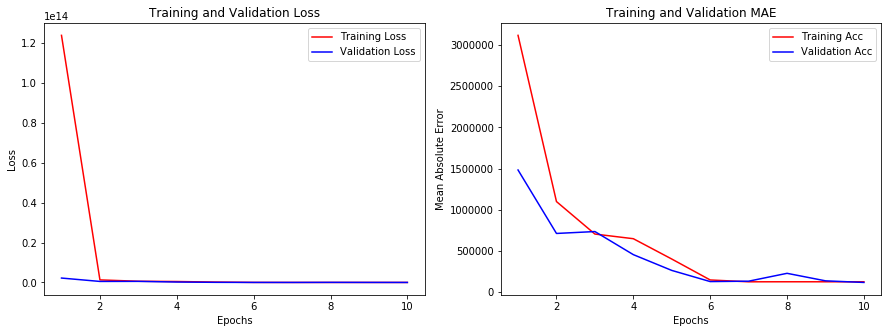

In [0]:
# plot a graph to show how the means absolute error improves during the training process
import matplotlib.pyplot as plt
history_dict = history.history
 
fig, (p1, p2) = plt.subplots(1, 2, figsize=(15,5))
 
x = range(1, EPOCHS+1)
 
p1.plot(x, history_dict['loss'], 'r', label='Training Loss')
p1.plot(x, history_dict['val_loss'], 'b', label='Validation Loss')
p1.set_title('Training and Validation Loss')
p1.set_xlabel('Epochs')
p1.set_ylabel('Loss')
p1.legend()
 
p2.plot(x, history_dict['mean_absolute_error'], 'r', label='Training Acc')
p2.plot(x, history_dict['val_mean_absolute_error'], 'b', label='Validation Acc')
p2.set_title('Training and Validation MAE')
p2.set_xlabel('Epochs')
p2.set_ylabel('Mean Absolute Error')
p2.legend()
 
plt.show()

As seen from the graph, the MAE for training is higher than validation. Also the MAE is around 125993, which is very high.

The data seems to be 'under-fitted'.


## Tried increasing the number of neurons on the input layers

In [0]:
# created another model with more neurons in hidden layers
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(72,)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1))

In [0]:
# compile the model
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

In [0]:
# Fit the model
EPOCHS = 10
history = model.fit(train_x, train_y, validation_split=0.2, epochs=EPOCHS, shuffle=True)

Train on 37218 samples, validate on 9305 samples
Epoch 1/10
37218/37218 [==============================] - 4s 119us/sample - loss: 344301810298536.0000 - mean_absolute_error: 12612841.0000 - val_loss: 3408003638687.4326 - val_mean_absolute_error: 1839495.5000
Epoch 2/10
37218/37218 [==============================] - 4s 103us/sample - loss: 1100689977465.3899 - mean_absolute_error: 848527.6875 - val_loss: 54860960707.5835 - val_mean_absolute_error: 210461.3281
Epoch 3/10
37218/37218 [==============================] - 4s 100us/sample - loss: 32080637155.4272 - mean_absolute_error: 137424.5000 - val_loss: 66048590455.2374 - val_mean_absolute_error: 232365.0312
Epoch 4/10
37218/37218 [==============================] - 4s 100us/sample - loss: 27165156558.8057 - mean_absolute_error: 126445.5781 - val_loss: 45675774111.7902 - val_mean_absolute_error: 157101.9375
Epoch 5/10
37218/37218 [==============================] - 4s 100us/sample - loss: 26748020867.1847 - mean_absolute_error: 125471.554

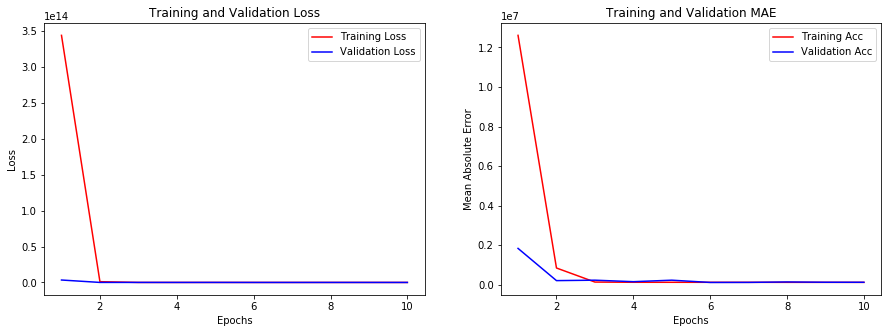

In [0]:
# plot a graph to show how the means absolute error improves during the training process
import matplotlib.pyplot as plt
history_dict = history.history
 
fig, (p1, p2) = plt.subplots(1, 2, figsize=(15,5))
 
x = range(1, EPOCHS+1)
 
p1.plot(x, history_dict['loss'], 'r', label='Training Loss')
p1.plot(x, history_dict['val_loss'], 'b', label='Validation Loss')
p1.set_title('Training and Validation Loss')
p1.set_xlabel('Epochs')
p1.set_ylabel('Loss')
p1.legend()
 
p2.plot(x, history_dict['mean_absolute_error'], 'r', label='Training Acc')
p2.plot(x, history_dict['val_mean_absolute_error'], 'b', label='Validation Acc')
p2.set_title('Training and Validation MAE')
p2.set_xlabel('Epochs')
p2.set_ylabel('Mean Absolute Error')
p2.legend()
 
plt.show()

The MAE is still around 121624, which is still high. 

Hence standardized the 'floor_area_sqm', 'resale_price' and normalised 'month' as the number of years from 2017.

## Standarised the floor area and resale price

In [0]:
# normalize the year of sale
sale_year = data.month.str.slice(0, 4).astype(int) - 2017

town_one_hot = pd.get_dummies(data['town'],prefix='town')

flat_type_one_hot = pd.get_dummies(data['flat_type'],prefix='flat_type')

storey_range_one_hot = pd.get_dummies(data['storey_range'],prefix='storey_range')

# standardized floor area
floor_area_sqm = data['floor_area_sqm']
floor_area_standardized = (floor_area_sqm - floor_area_sqm.mean(axis=0))/floor_area_sqm.std(axis=0)

flat_model_one_hot = pd.get_dummies(data['flat_model'], prefix='flat_model')

remaining_lease_yrs =  data.remaining_lease.str.slice(0, 2).astype(int)

In [0]:
# concatenated the required columns to create input dataset
data_oh = pd.concat([sale_year, town_one_hot, flat_type_one_hot, storey_range_one_hot, floor_area_standardized, flat_model_one_hot, remaining_lease_yrs], axis=1, sort=False)

data_oh.columns = ['sale_year', 'town_ANG MO KIO', 'town_BEDOK', 'town_BISHAN',
       'town_BUKIT BATOK', 'town_BUKIT MERAH', 'town_BUKIT PANJANG',
       'town_BUKIT TIMAH', 'town_CENTRAL AREA', 'town_CHOA CHU KANG',
       'town_CLEMENTI', 'town_GEYLANG', 'town_HOUGANG', 'town_JURONG EAST',
       'town_JURONG WEST', 'town_KALLANG/WHAMPOA', 'town_MARINE PARADE',
       'town_PASIR RIS', 'town_PUNGGOL', 'town_QUEENSTOWN', 'town_SEMBAWANG',
       'town_SENGKANG', 'town_SERANGOON', 'town_TAMPINES', 'town_TOA PAYOH',
       'town_WOODLANDS', 'town_YISHUN', 'flat_type_1 ROOM', 'flat_type_2 ROOM',
       'flat_type_3 ROOM', 'flat_type_4 ROOM', 'flat_type_5 ROOM',
       'flat_type_EXECUTIVE', 'flat_type_MULTI-GENERATION',
       'storey_range_01 TO 03', 'storey_range_04 TO 06',
       'storey_range_07 TO 09', 'storey_range_10 TO 12',
       'storey_range_13 TO 15', 'storey_range_16 TO 18',
       'storey_range_19 TO 21', 'storey_range_22 TO 24',
       'storey_range_25 TO 27', 'storey_range_28 TO 30',
       'storey_range_31 TO 33', 'storey_range_34 TO 36',
       'storey_range_37 TO 39', 'storey_range_40 TO 42',
       'storey_range_43 TO 45', 'storey_range_46 TO 48',
       'storey_range_49 TO 51', 'floor_area_sqm_standardized', 'flat_model_Adjoined flat',
       'flat_model_Apartment', 'flat_model_DBSS', 'flat_model_Improved',
       'flat_model_Improved-Maisonette', 'flat_model_Maisonette',
       'flat_model_Model A', 'flat_model_Model A-Maisonette',
       'flat_model_Model A2', 'flat_model_Multi Generation',
       'flat_model_New Generation', 'flat_model_Premium Apartment',
       'flat_model_Premium Apartment Loft', 'flat_model_Premium Maisonette',
       'flat_model_Simplified', 'flat_model_Standard', 'flat_model_Terrace',
       'flat_model_Type S1', 'flat_model_Type S2', 'remaining_lease_yrs']

data_oh.shape

(58154, 72)

In [0]:
# standardised resale price
resale_price = data['resale_price']
resale_price_standardized = (resale_price - resale_price.mean(axis=0))/resale_price.std(axis=0)
resale_price_standardized

0       -1.345713
1       -1.229015
2       -1.151216
3       -1.131767
4       -1.131767
           ...   
58149    0.676325
58150    1.661775
58151    1.980179
58152    1.072528
58153    1.299441
Name: resale_price, Length: 58154, dtype: float64

In [0]:
# Split dataset into random train and test subsets
train_x, test_x, train_y, test_y = train_test_split(data_oh.values, resale_price_standardized.astype(np.float64), test_size = 0.2, random_state = 0)


In [0]:
# Created another model
model = models.Sequential()
model.add(layers.Dense(64, name="hidden1", input_shape=(72,), activation="relu"))
model.add(layers.Dense(64, name="hidden2", activation="relu", ))
model.add(layers.Dense(1, name="output"))
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 64)                4672      
_________________________________________________________________
hidden2 (Dense)              (None, 64)                4160      
_________________________________________________________________
output (Dense)               (None, 1)                 65        
Total params: 8,897
Trainable params: 8,897
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
# compile model
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

In [0]:
# Fit the model with standardized inputs
EPOCHS=100
history = model.fit(train_x, train_y, validation_split=0.2, epochs=EPOCHS, batch_size=32)

Train on 37218 samples, validate on 9305 samples
Epoch 1/100
37218/37218 [==============================] - 3s 87us/sample - loss: 0.4407 - mean_absolute_error: 0.4946 - val_loss: 0.1767 - val_mean_absolute_error: 0.3422
Epoch 2/100
37218/37218 [==============================] - 3s 71us/sample - loss: 0.1608 - mean_absolute_error: 0.3020 - val_loss: 0.1177 - val_mean_absolute_error: 0.2509
Epoch 3/100
37218/37218 [==============================] - 3s 71us/sample - loss: 0.1279 - mean_absolute_error: 0.2650 - val_loss: 0.2893 - val_mean_absolute_error: 0.4033
Epoch 4/100
37218/37218 [==============================] - 3s 72us/sample - loss: 0.1169 - mean_absolute_error: 0.2521 - val_loss: 0.1059 - val_mean_absolute_error: 0.2358
Epoch 5/100
37218/37218 [==============================] - 3s 72us/sample - loss: 0.1107 - mean_absolute_error: 0.2448 - val_loss: 0.1348 - val_mean_absolute_error: 0.2897
Epoch 6/100
37218/37218 [==============================] - 3s 72us/sample - loss: 0.1058 - 

37218/37218 [==============================] - 3s 72us/sample - loss: 0.0671 - mean_absolute_error: 0.1864 - val_loss: 0.0952 - val_mean_absolute_error: 0.2284
Epoch 96/100
37218/37218 [==============================] - 3s 72us/sample - loss: 0.0671 - mean_absolute_error: 0.1861 - val_loss: 0.0900 - val_mean_absolute_error: 0.2191
Epoch 97/100
37218/37218 [==============================] - 3s 72us/sample - loss: 0.0668 - mean_absolute_error: 0.1857 - val_loss: 0.0992 - val_mean_absolute_error: 0.2266
Epoch 98/100
37218/37218 [==============================] - 3s 71us/sample - loss: 0.0668 - mean_absolute_error: 0.1858 - val_loss: 0.0737 - val_mean_absolute_error: 0.1940
Epoch 99/100
37218/37218 [==============================] - 3s 71us/sample - loss: 0.0668 - mean_absolute_error: 0.1859 - val_loss: 0.0797 - val_mean_absolute_error: 0.2052
Epoch 100/100
37218/37218 [==============================] - 3s 72us/sample - loss: 0.0663 - mean_absolute_error: 0.1852 - val_loss: 0.0740 - val_me

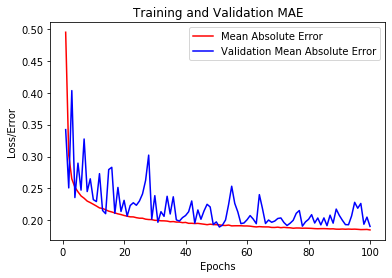

In [0]:
# plot a graph to show how the means absolute error improves during the training process
import matplotlib.pyplot as plt
history_dict = history.history

x = range(1, EPOCHS+1)

plt.plot(x, history_dict['mean_absolute_error'], 'r', label='Mean Absolute Error')
plt.plot(x, history_dict['val_mean_absolute_error'], 'b', label='Validation Mean Absolute Error')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Loss/Error')
plt.legend()

As seen from the graph, the MAE has reduced to 0.2196, which is nice.


Still wanted to try other optimizer like 'adam' to see if MAE will become even less.


## Adam optimiser

In [0]:
# Created another model
model_adam = models.Sequential()
model_adam.add(layers.Dense(64, name="hidden1", input_shape=(72,), activation="relu"))
model_adam.add(layers.Dense(64, name="hidden2", activation="relu", ))
model_adam.add(layers.Dense(1, name="output"))
print(model_adam.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 64)                4672      
_________________________________________________________________
hidden2 (Dense)              (None, 64)                4160      
_________________________________________________________________
output (Dense)               (None, 1)                 65        
Total params: 8,897
Trainable params: 8,897
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
# Compiled the model with adam optimizer
model_adam.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [0]:
# Fit the model with standardised inputs
EPOCHS=10
history = model_adam.fit(train_x, train_y, validation_split=0.2, epochs=EPOCHS, batch_size=32)

Train on 37218 samples, validate on 9305 samples
Epoch 1/10
37218/37218 [==============================] - 3s 92us/sample - loss: 0.4303 - mean_absolute_error: 0.4127 - val_loss: 0.1988 - val_mean_absolute_error: 0.3416
Epoch 2/10
37218/37218 [==============================] - 3s 69us/sample - loss: 0.1290 - mean_absolute_error: 0.2729 - val_loss: 0.1722 - val_mean_absolute_error: 0.3226
Epoch 3/10
37218/37218 [==============================] - 3s 71us/sample - loss: 0.1211 - mean_absolute_error: 0.2634 - val_loss: 0.1193 - val_mean_absolute_error: 0.2518
Epoch 4/10
37218/37218 [==============================] - 3s 70us/sample - loss: 0.1152 - mean_absolute_error: 0.2572 - val_loss: 0.1280 - val_mean_absolute_error: 0.2579
Epoch 5/10
37218/37218 [==============================] - 3s 73us/sample - loss: 0.1070 - mean_absolute_error: 0.2444 - val_loss: 0.1086 - val_mean_absolute_error: 0.2396
Epoch 6/10
37218/37218 [==============================] - 3s 73us/sample - loss: 0.1057 - mean_a

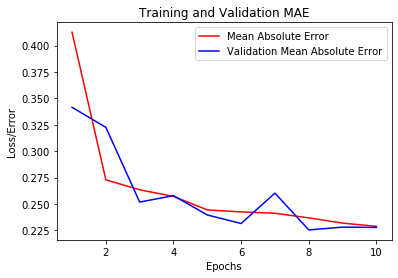

In [0]:
# plot a graph to show how the means absolute error improves during the training process
import matplotlib.pyplot as plt
history_dict = history.history

x = range(1, EPOCHS+1)

plt.plot(x, history_dict['mean_absolute_error'], 'r', label='Mean Absolute Error')
plt.plot(x, history_dict['val_mean_absolute_error'], 'b', label='Validation Mean Absolute Error')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Loss/Error')
plt.legend()

With Adam optimizer, there isn't much difference in the MAE. The error is around 0.2289


# Increasing number of input features

Earlier, I excluded 2 input features, **'block'** and **'street_name'**. Since the training error is still more than validation error, I am going to try with all the input features in the dataset.

In [0]:
#one-hot encodin the 'block'
block_one_hot = pd.get_dummies(data['block'],prefix='block')
#one-hot encodin the 'streetname'
street_name_one_hot = pd.get_dummies(data['street_name'],prefix='town')


data_oh = pd.concat([sale_year, town_one_hot, flat_type_one_hot, block_one_hot, street_name_one_hot, storey_range_one_hot, floor_area_standardized, flat_model_one_hot, remaining_lease_yrs], axis=1, sort=False)

data_oh.shape

(58154, 2953)

In [0]:
data_oh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58154 entries, 0 to 58153
Columns: 2953 entries, month to remaining_lease
dtypes: float64(1), int64(2), uint8(2950)
memory usage: 164.9 MB


In [0]:
data_oh.head(1)

,month,town_ANG MO KIO,town_BEDOK,town_BISHAN,town_BUKIT BATOK,town_BUKIT MERAH,town_BUKIT PANJANG,town_BUKIT TIMAH,town_CENTRAL AREA,town_CHOA CHU KANG,...,flat_model_New Generation,flat_model_Premium Apartment,flat_model_Premium Apartment Loft,flat_model_Premium Maisonette,flat_model_Simplified,flat_model_Standard,flat_model_Terrace,flat_model_Type S1,flat_model_Type S2,remaining_lease
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,61


In [0]:
# Split dataset into random train and test subsets
train_x, test_x, train_y, test_y = train_test_split(data_oh.values, resale_price_standardized.astype(np.float64), test_size = 0.2, random_state = 0)

# print the shape of the train & test subsets
print("train_x: ",train_x.shape)
print("test_x: ",test_x.shape)
print("train_y: ",train_y.shape)
print("test_y: ",test_y.shape)

train_x:  (46523, 2953)
test_x:  (11631, 2953)
train_y:  (46523,)
test_y:  (11631,)


Since there are **2953 input features**, the input shape for the first hidden layer will be 2953.

**Also tried to keep the number of neurons as multiples of 2.** Hence chose **2048, 1024, 512, 256, 128, 64, 32, 16** for the hidden layers.

In [0]:
# Created a model 
model = models.Sequential()
model.add(layers.Dense(2953, name="hidden1", input_shape=(2953,), activation="relu"))
model.add(layers.Dense(2048, name="hidden2", activation="relu", ))
model.add(layers.Dense(1024, name="hidden3", activation="relu", ))
model.add(layers.Dense(512, name="hidden4", activation="relu", ))
model.add(layers.Dense(256, name="hidden5", activation="relu", ))
model.add(layers.Dense(128, name="hidden6", activation="relu", ))
model.add(layers.Dense(64, name="hidden7", activation="relu", ))
model.add(layers.Dense(32, name="hidden8", activation="relu", ))
model.add(layers.Dense(16, name="hidden9", activation="relu", ))
model.add(layers.Dense(1, name="output"))
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 2953)              8723162   
_________________________________________________________________
hidden2 (Dense)              (None, 2048)              6049792   
_________________________________________________________________
hidden3 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
hidden4 (Dense)              (None, 512)               524800    
_________________________________________________________________
hidden5 (Dense)              (None, 256)               131328    
_________________________________________________________________
hidden6 (Dense)              (None, 128)               32896     
_________________________________________________________________
hidden7 (Dense)              (None, 64)               

The model has an input shape of (2953,) because there are 2953 features. RELU is used as our activation function for our hidden layer.

As can be seen from the summary, there are **9 hidden layers and 1 output layer**. 

There are a 8723162 weights for the first layer, 6049792 weights in the second layer, 2098176 weights in third layer, 524800 weights in fourth layer, 131328 weights in fifth layer, 32896 weights in sixth layer, 8256 weights in seventh layer, 2080 weights in eight layer, 528 weights in ninth layer and 17 weights in the final output layers making a **total of 17,571,035 weights** (parameters).

In [0]:
# compile model
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

NameError: ignored

In [0]:
# Fit the model with standardized inputs
EPOCHS=10
history = model.fit(train_x, train_y, validation_split=0.2, epochs=EPOCHS, batch_size=32)

Train on 37218 samples, validate on 9305 samples
Epoch 1/10
37218/37218 [==============================] - 253s 7ms/sample - loss: 0.5759 - mean_absolute_error: 0.4295 - val_loss: 0.1319 - val_mean_absolute_error: 0.3062
Epoch 2/10
37218/37218 [==============================] - 294s 8ms/sample - loss: 0.0968 - mean_absolute_error: 0.2240 - val_loss: 0.1241 - val_mean_absolute_error: 0.3048
Epoch 3/10
37218/37218 [==============================] - 270s 7ms/sample - loss: 0.0713 - mean_absolute_error: 0.1932 - val_loss: 0.0692 - val_mean_absolute_error: 0.1895
Epoch 4/10
37218/37218 [==============================] - 258s 7ms/sample - loss: 0.0609 - mean_absolute_error: 0.1775 - val_loss: 0.0963 - val_mean_absolute_error: 0.2209
Epoch 5/10
37218/37218 [==============================] - 266s 7ms/sample - loss: 0.0534 - mean_absolute_error: 0.1656 - val_loss: 0.1058 - val_mean_absolute_error: 0.2808
Epoch 6/10
37218/37218 [==============================] - 259s 7ms/sample - loss: 0.0487 - 

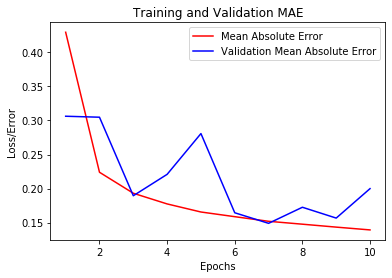

In [0]:
# plot a graph to show how the means absolute error improves during the training process
import matplotlib.pyplot as plt
history_dict = history.history

x = range(1, EPOCHS+1)

plt.plot(x, history_dict['mean_absolute_error'], 'r', label='Mean Absolute Error')
plt.plot(x, history_dict['val_mean_absolute_error'], 'b', label='Validation Mean Absolute Error')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Loss/Error')
plt.legend()

As you can see from the graph above, the MAE is reduced to 0.1393

# Evaluated for test data

In [0]:
# Evaluate the model with 'rmsprop' optimizer, as it had lower val_mae
test_result = model.evaluate(test_x, test_y, batch_size=128)
print(test_result)

11631/11631 [==============================] - 2s 182us/sample - loss: 0.0602 - mean_absolute_error: 0.2011
[0.06017671791511045, 0.20111503]


## Conclusion
* From the graph above, one can see that MAE has **reduced to 0.1393** from 0.2196, during training.
* Standardising the input values, adding more features and increasing depth and width of the hidden layers helped to reduce Mean Absolute Error and overcome 'under-fitting'.
* The above model training took a long time and there are a total of 17,571,035 weights in it. I can understand why convolution networks got invented later. If convnet is used, definitely the number of filters will be much lessers than the total number of parameters used here(17,571,035).
* Also since there was no problem of overfitting, I didn't have to use regularization or use dropout layers.